In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from feature_engine.outliers import Winsorizer
from sklearn.base import BaseEstimator, TransformerMixin
from statsmodels.tsa.seasonal import STL
from feature_engine.outliers import Winsorizer
from sklearn.pipeline import Pipeline

In [326]:
def load_data(path,date_col):
    # Load data: only the time variable and CO.
    data = pd.read_csv(
        path,
        parse_dates=[date_col],
        index_col=[date_col],
    )
    data = data.sort_index()
    return data

In [327]:
df = load_data(r"C:\Users\Omar Anwar\Desktop\Grad Project\Udemy - Feature Engineering for Time Series Forecasting 2023\feature-engineering-for-time-series-forecasting-main\Datasets\example_retail_sales_with_outliers.csv",'ds')
df.head()

,y
ds,
1992-01-01,146376.0
1992-02-01,147079.0
1992-03-01,159336.0
1992-04-01,163669.0
1992-05-01,170068.0


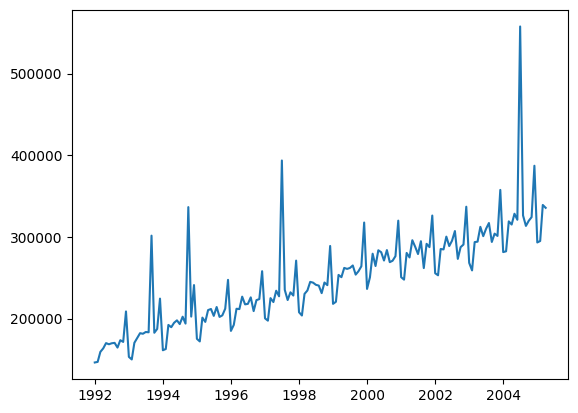

In [328]:
plt.plot(df.index,df.y)
plt.show()

In [329]:
class OutlierHandler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.capper = None
    def fit(self, X, y=None,capping_method="iqr",tail='both',fold=1.5):
        Decomposed = STL(X,robust=True).fit()
        residuals = Decomposed.resid
        self.capper = Winsorizer(capping_method=capping_method, tail=tail, fold=fold)
        self.capper.fit(pd.DataFrame(residuals))
        return self
    
    def transform(self, X):
        Decomposed = STL(X,robust=True).fit()
        residuals = Decomposed.resid
        residuals = self.capper.transform(pd.DataFrame(residuals))
        X['y'] = residuals.resid + Decomposed.trend + Decomposed.seasonal
        return X

In [330]:
class OutlierHandler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.cappers = {}
    def fit(self, X, y=None, capping_method="iqr", tail='both', fold=1.5):
        for col in X.select_dtypes(include='number'):
            decomposed = STL(X[col], robust=True).fit()
            residuals = decomposed.resid
            capper = Winsorizer(capping_method=capping_method, tail=tail, fold=fold)
            capper.fit(pd.DataFrame(residuals))
            self.cappers[col] = capper
        return self
    
    def transform(self, X):
        for col in X.select_dtypes(include='number'):
            decomposed = STL(X[col], robust=True).fit()
            residuals = decomposed.resid
            capper = self.cappers[col]
            residuals = capper.transform(pd.DataFrame(residuals))
            X[col] = residuals.resid + decomposed.trend + decomposed.seasonal
        return X

In [331]:
coco = OutlierHandler().fit(df)

In [332]:
df2 = coco.transform(df)

In [333]:
df2

,y
ds,
1992-01-01,146376.0
1992-02-01,147079.0
1992-03-01,159336.0
1992-04-01,163669.0
1992-05-01,170068.0
...,...
2004-12-01,387155.0
2005-01-01,293261.0
2005-02-01,295062.0


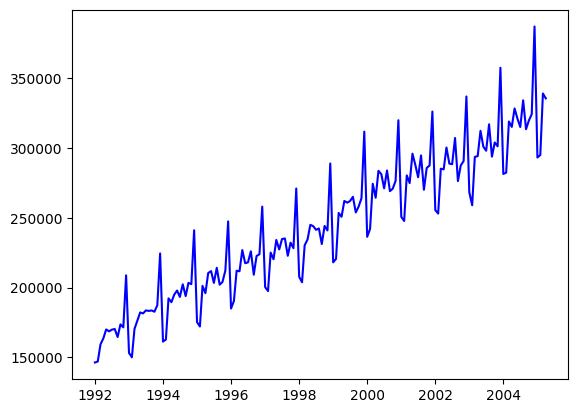

In [334]:
plt.plot(df2.index,df2.y,'b')
plt.show()

In [335]:
df3 = load_data(r"C:\Users\Omar Anwar\Desktop\Grad Project\Udemy - Feature Engineering for Time Series Forecasting 2023\feature-engineering-for-time-series-forecasting-main\Datasets\example_retail_sales_with_missing_data.csv",'ds')
df3.head()

,y
ds,
1992-01-01,146376.0
1992-02-01,147079.0
1992-03-01,159336.0
1992-04-01,163669.0
1992-05-01,170068.0


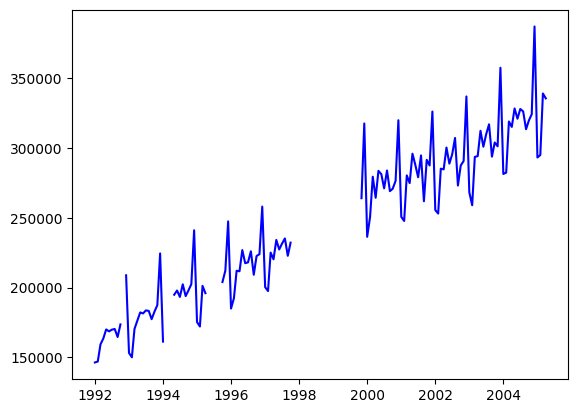

In [336]:
plt.plot(df3.index,df3.y,'b')
plt.show()

In [337]:
from sklearn.base import BaseEstimator, TransformerMixin
from statsmodels.tsa.seasonal import STL

class MissingValuesHandler(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        df = X.copy()
        numerical_cols = df.select_dtypes(include='number').columns
        for col in numerical_cols:
            # Interpolate data to decompose seasonality
            df[col] = df[col].interpolate(method="linear")
            decomposed = STL(df[col], robust=True).fit()
            y_deseasonalized = X[col] - decomposed.seasonal
            # Remove seasonality then interpolate on Trend and Residuals
            y_deseasonalized = y_deseasonalized.interpolate(method="linear")
            # Re-adding Seasonal Component
            X[col] = y_deseasonalized + decomposed.seasonal
        
        return X

In [338]:
coco2 = MissingValuesHandler()
df4 = coco2.transform(df3)

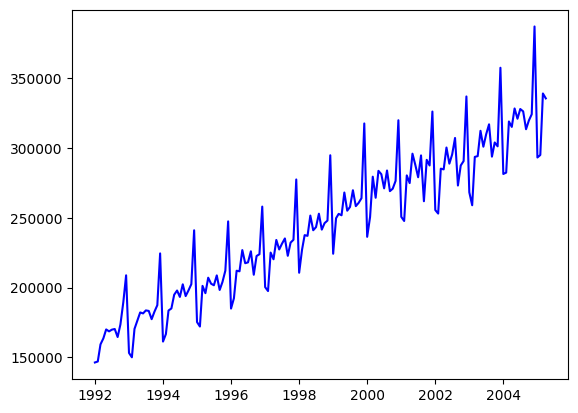

In [339]:
plt.plot(df4.index,df4.y,'b')
plt.show()

In [340]:
import sklearn
sklearn.set_config(display="diagram")

In [348]:
from sklearn.pipeline import make_pipeline
Data_Preprocssing_Pipeline = make_pipeline(
    OutlierHandler(),
    MissingValuesHandler(),
)
Data_Preprocssing_Pipeline

Pipeline(steps=[('outlierhandler', OutlierHandler()),
                ('missingvalueshandler', MissingValuesHandler())])